# Importando bibliotecas
import torch	Importa o PyTorch, a principal biblioteca de redes neurais

import torchvision	Contém datasets, modelos prontos e ferramentas para visão computacional

import torchvision.transforms as transforms	Serve para transformar e preparar imagens (ex: redimensionar, normalizar etc.)

import torch.nn as nn	Contém as camadas de redes neurais (ex: Linear, ReLU, etc.)

import torch.optim as optim	Algoritmos de otimização, como o SGD ou Adam

import torchvision.models as models	Contém modelos famosos já treinados, como ResNet, AlexNet, VGG etc.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models


# Carregando modelo pré-treinado(ResNet18)
O modelo ResNet18 é uma rede neural já treinada com milhões de imagens (no banco ImageNet). Vamos carregar esse modelo para usar o que ele já aprendeu.

models.resnet18(pretrained=True) → Carrega a arquitetura da ResNet18 com pesos já treinados.

Esse modelo já sabe reconhecer milhares de objetos em imagens (gato, cachorro, carro...).

Vamos usar esse “conhecimento” dele para treinar algo novo com menos dados.

In [ ]:
# Carregar o modelo ResNet18 pré-treinado
model = models.resnet18(pretrained=True)

# Ver a estrutura do modelo (opcional)
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Agora vamos -->

Congelar as camadas antigas (para não “esquecer” o que já aprendeu).

Trocar a última camada (fully connected) para classificar apenas 2 categorias.

In [ ]:
# Congelar todas as camadas antigas (evita que elas sejam atualizadas durante o treino)
for param in model.parameters():
    param.requires_grad = False

# Substituir a última camada (fc = fully connected) por uma nova que classifica 2 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Agora temos só duas saídas: gato e carro


# Carregar as imagens com o ImageFolder do PyTorch

A gente só precisa aplicar transformações (como redimensionar e normalizar as imagens) e montar os DataLoaders

In [ ]:
#Descomparctar data.zip
import zipfile
import os

zip_path = '/content/data.zip'
extract_path = '/content/data'

# Descompactar o zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verificar estrutura
for root, dirs, files in os.walk(extract_path):
    print(f'📁 {root} - {len(files)} arquivos')


📁 /content/data - 0 arquivos
📁 /content/data/data - 0 arquivos
📁 /content/data/data/train - 0 arquivos
📁 /content/data/data/train/dog - 101 arquivos
📁 /content/data/data/train/cat - 101 arquivos
📁 /content/data/data/val - 0 arquivos
📁 /content/data/data/val/dog - 20 arquivos
📁 /content/data/data/val/cat - 20 arquivos


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformações para as imagens (ex: redimensionar e normalizar)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Tamanho esperado pela ResNet18
    transforms.ToTensor(),          # Converte imagem em tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normaliza RGB
])

# Caminhos das pastas
train_path = '/content/data/data/train'
val_path = '/content/data/data/val'


# Carregar datasets
train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)

# Criar DataLoaders (batch = grupo de imagens)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Verificar classes
print(f'Classes detectadas: {train_dataset.classes}')


Classes detectadas: ['cat', 'dog']


#Treinar o modelo para classificar gato e cachorro



In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch

# Usar GPU se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Função de custo (quão errado o modelo está)
criterion = nn.CrossEntropyLoss()

# Otimizador (como o modelo vai aprender)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Número de épocas (quantas vezes passar pelo dataset)
epochs = 15

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()             # Zera os gradientes anteriores
        outputs = model(images)           # Faz a previsão
        loss = criterion(outputs, labels) # Calcula o erro
        loss.backward()                   # Calcula os gradientes
        optimizer.step()                  # Atualiza os pesos

        running_loss += loss.item()

    print(f"Época {epoch+1}/{epochs} - Loss: {running_loss:.4f}")


Época 1/15 - Loss: 5.9440
Época 2/15 - Loss: 4.1152
Época 3/15 - Loss: 3.6544
Época 4/15 - Loss: 2.9982
Época 5/15 - Loss: 2.8763
Época 6/15 - Loss: 2.7800
Época 7/15 - Loss: 2.2575
Época 8/15 - Loss: 1.7550
Época 9/15 - Loss: 2.3658
Época 10/15 - Loss: 2.2552
Época 11/15 - Loss: 1.9275
Época 12/15 - Loss: 1.3337
Época 13/15 - Loss: 1.4580
Época 14/15 - Loss: 2.1680
Época 15/15 - Loss: 1.4909


#Teste de imagem

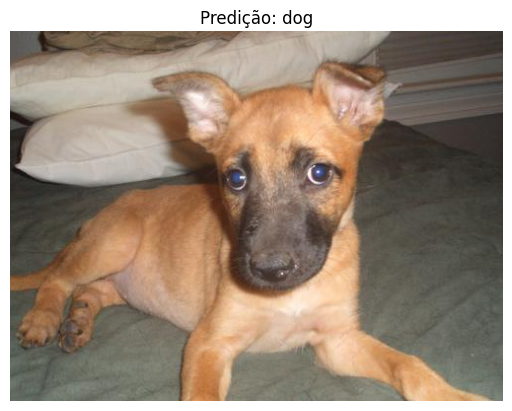

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def prever_imagem(caminho_imagem):
    # Abrir imagem e aplicar as mesmas transformações do treino
    imagem = Image.open(caminho_imagem).convert('RGB')
    transformada = transform(imagem).unsqueeze(0).to(device)  # Adiciona dimensão do batch

    model.eval()
    with torch.no_grad():
        saida = model(transformada)
        _, predicao = torch.max(saida, 1)

    # Mostrar resultado
    classe = train_dataset.classes[predicao.item()]
    plt.imshow(imagem)
    plt.title(f"Predição: {classe}")
    plt.axis('off')
    plt.show()

# Exemplo: prever imagem que você subiu
prever_imagem("/content/421.jpg")  # Troque pelo nome real do seu arquivo
